# Multi-Layer Perceptron
---
TUTURIAL: [Multi-Layer Perceptron, MNIST](https://www.kaggle.com/code/mishra1993/pytorch-multi-layer-perceptron-mnist/notebook) by Digit Recognizer

Purpose of this notebook is to provide me with training and understanding of MLP, Torch for HW2. In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

In [1]:
# import libraries
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, Dataset

from torch_models import Net
from data_loader import TrainMNIST, TestMNIST

%matplotlib inline

/var/folders/fz/zn5r8vq12nv5p23dtlr15sk40000gn/T/ipykernel_74751/1563945520.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Pipeline

1. Load and visualize the data
2. Define a neural network
3. Train the neural network
4. Evaluate the performance of our trained model on a test dataset!

# Load and visualize the data

In [2]:
reshape_height, reshape_width, reshape_channels = 28, 28, 1
train_data = TrainMNIST('../datasets/digit-recognizer/train.csv',  reshape_height, reshape_width, reshape_channels, transform=transforms.ToTensor())
test_data = TestMNIST('../datasets/digit-recognizer/test.csv',  reshape_height, reshape_width, reshape_channels, transform=transforms.ToTensor())

In [3]:
len(train_data), len(test_data)

(42000, 28000)

In [4]:
train_data

In [5]:
# as a positive integer will turn on multi-process data loading with the specified number of loader worker processes; otherwise, single-process data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# select a sampling method to use
sample_method = 'subset'

number_of_training_samples = len(train_data)
indices = list(range(number_of_training_samples))

# print("Before shuffle indices --", indices)
np.random.shuffle(indices)
# print("After shuffle indices --", indices)

split_idx = int(np.floor(valid_size * number_of_training_samples))
train_idx, valid_idx = indices[split_idx:], indices[:split_idx]

# prepare data loaders
train_loader = train_data.prepare_data_loader(batch_size, sample_method, train_idx, num_workers)
valid_loader = train_data.prepare_data_loader(batch_size, sample_method, valid_idx, num_workers)

Sampling Method --  subset
Sampling Method --  subset


In [6]:
len(train_loader), type(train_loader), len(valid_loader), type(valid_loader)

(1680,
 torch.utils.data.dataloader.DataLoader,
 420,
 torch.utils.data.dataloader.DataLoader)

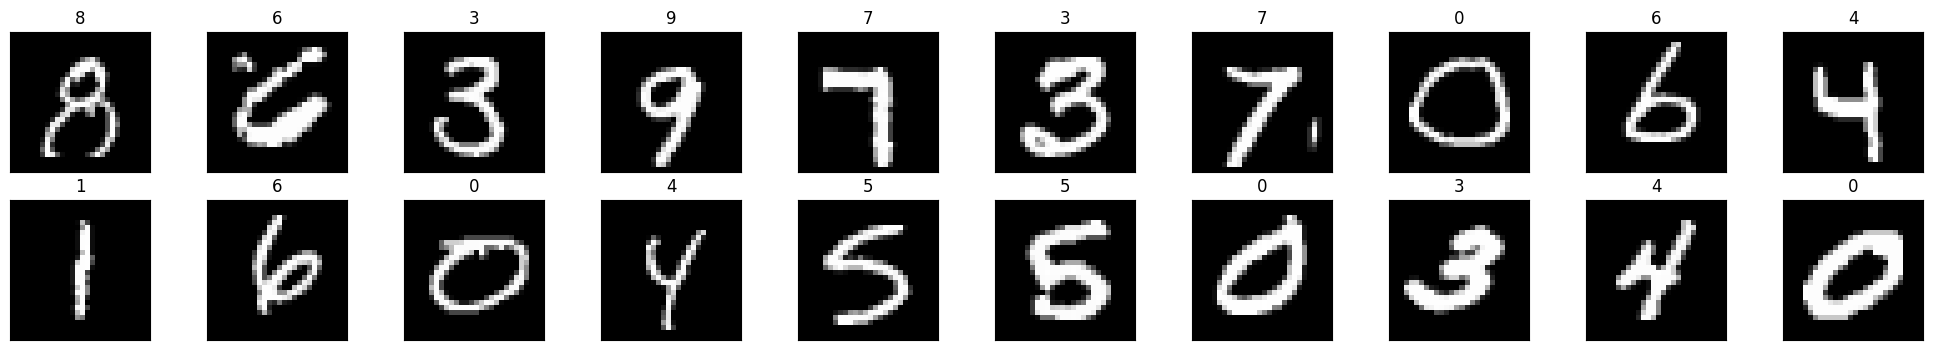

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

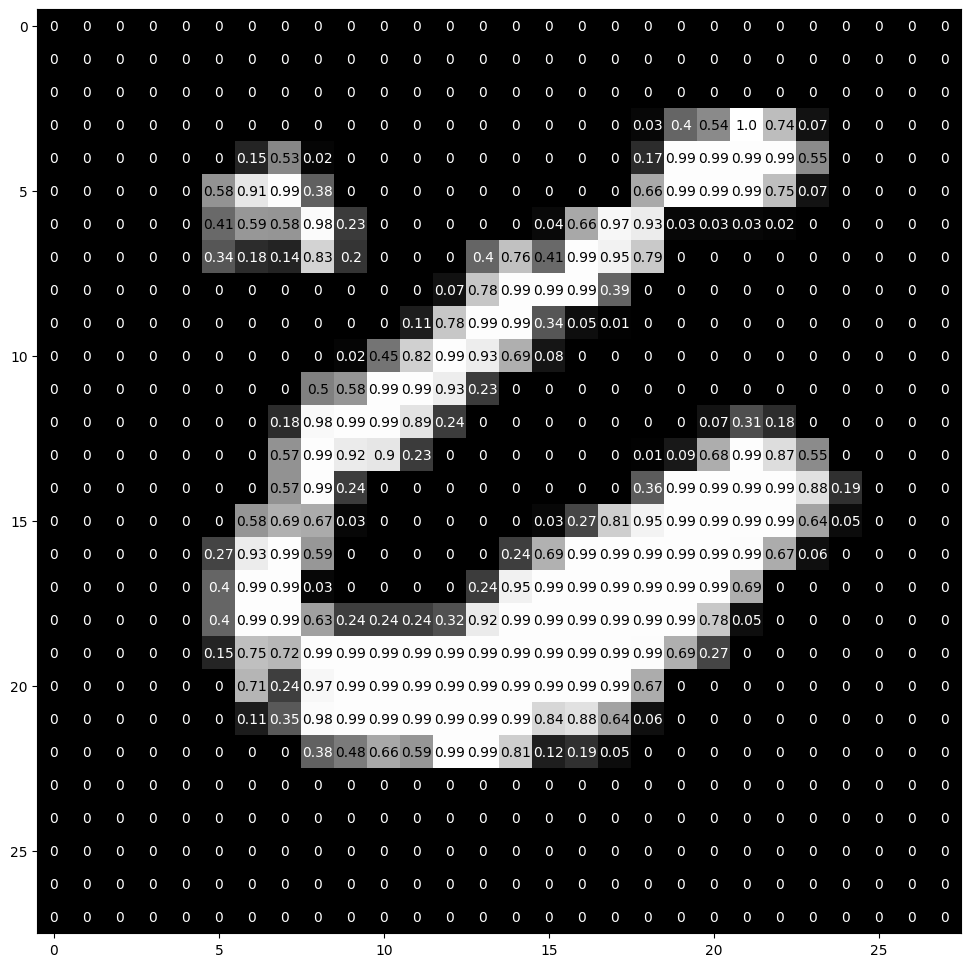

In [8]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define a neural network
- The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [9]:
hidden_1 = 512
hidden_2 = 512
dropout_rate = 0.2

net_model = Net(hidden_1, hidden_2, reshape_height, reshape_width, dropout_rate)
print(net_model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify Loss Function and Optimizer

- It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_model.parameters(), lr=0.01)

## Train the neural network

In [11]:
number_of_epochs = 3
net_model.train_network(number_of_epochs, optimizer, criterion, train_loader, valid_loader)

Epoch: 1 	Training Loss: 0.927695 	Validation Loss: 0.089069
Validation loss decreased (inf --> 0.089069).  Saving model ...
Epoch: 2 	Training Loss: 0.324995 	Validation Loss: 0.066475
Validation loss decreased (0.089069 --> 0.066475).  Saving model ...
Epoch: 3 	Training Loss: 0.260635 	Validation Loss: 0.056820
Validation loss decreased (0.066475 --> 0.056820).  Saving model ...


### Load model with lowest validation loss

In [12]:
net_model.load_state_dict(torch.load('nn_model.pt'))

<All keys matched successfully>

### Test the trained model

- Test our best model on previously **unseen test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
test_batch_size = 1
test_loader = test_data.prepare_data_loader(test_batch_size, num_workers)

In [14]:
predictions = net_model.predict(test_loader)
predictions = np.array(predictions)
predictions_flat = predictions.flatten()


In [15]:
test_data = pd.read_csv("../datasets/digit-recognizer/test.csv")


submission = pd.DataFrame(data={
    "ImageId": test_data.index + 1,
    "Label": predictions_flat
})
submission.to_csv("submission.csv", index=None)

In [16]:
submission.head(n=12).T


,0,1,2,3,4,5,6,7,8,9,10,11
ImageId,1,2,3,4,5,6,7,8,9,10,11,12
Label,2,0,9,9,3,7,0,3,0,3,5,7
